This notebook is a manual version of the `.py` file with the same name

In [1]:
SELECTION = 'sel_T17XNA_10h'
OVERLAP = 0.5
MASKS = 'West_SeaIce,East_SeaIce'
TILE_QUANTITY = 5
TILESIZE = 256


In [2]:
import os
import sys
import json
import pandas as pd
import random

sys.path.append('.')
sys.path.append('..')
from environment import Environment
env = Environment()

import snap_toolbox as stbx


environment loaded


In [3]:
with open(os.path.join(env.DATA_ROOT, '_inventory', f'{SELECTION}.json'), "r") as json_file:
    selection = json.load(json_file)

invname = selection.get('inventory', None)
inventory = pd.read_csv(os.path.join(env.DATA_ROOT, '_inventory', f'{invname}.csv'), index_col='index')

s2_indices = selection.get('s2_indices', [])
masks = MASKS.split(',')


In [4]:
sel_index = 3

In [5]:
targetpairs = inventory[(inventory['s2'] == inventory['s2'][s2_indices[sel_index]]) &
                       (inventory['overlap'] >= OVERLAP)].sort_values('timediff')
targetpair = targetpairs.iloc[0]
inv_index = targetpairs.index[0]


In [6]:
s2_raw = stbx.read_product(targetpair['s2'])
s3_raw = stbx.read_product(targetpair['s3'])

s2_filename = os.path.basename(targetpair['s2'])
s3_filename = os.path.basename(targetpair['s3'])

s2_polygon = stbx.get_metadata_polygon(s2_raw, 's2')
s3_polygon = stbx.get_metadata_polygon(s3_raw, 's3')


In [217]:
import importlib
importlib.reload(stbx)

<module 'snap_toolbox' from '/home/cb/sis2/preprocessing/snap_toolbox.py'>

In [7]:
maskpaths = [os.path.join(env.DATA_ROOT, '_masks', f'{maskname}.kml') for maskname in masks]
polygons = [stbx.load_kml(maskpath) for maskpath in maskpaths]


In [182]:
targetdir_png = os.path.join(env.DATA_ROOT, '_inventory', SELECTION)
if not os.path.exists(targetdir_png):
    os.makedirs(targetdir_png)


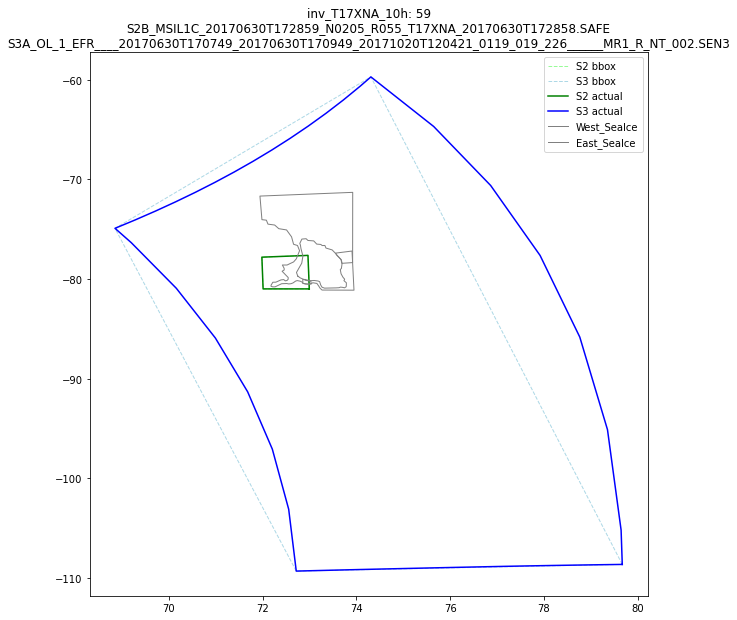

In [9]:
stbx.plot_polygons(s2_raw, s3_raw,
                   polygons=polygons,
                   polygon_labels=masks,
                   title=f'{invname}: {inv_index}\n{s2_filename}\n{s3_filename}',
                   )
                #    savefig=os.path.join(targetdir_png, f'{inv_index}.png'))


In [184]:
s2_subset = stbx.band_subset(s2_raw, 'B2,B3,B4')
s3_subset = stbx.band_subset(s3_raw, 'Oa01_radiance,Oa02_radiance,Oa03_radiance,Oa04_radiance,Oa05_radiance,Oa06_radiance,Oa07_radiance,Oa08_radiance,Oa09_radiance,Oa10_radiance,Oa11_radiance,Oa12_radiance,Oa13_radiance,Oa14_radiance,Oa15_radiance,Oa16_radiance,Oa17_radiance,Oa18_radiance,Oa19_radiance,Oa20_radiance,Oa21_radiance')

#TODO: Dispose S2/S3

collocated = stbx.collocate(s2_subset, s3_subset)
collocated = stbx.band_subset(collocated,'B2,B3,B4,Oa01_radiance,Oa02_radiance,Oa03_radiance,Oa04_radiance,Oa05_radiance,Oa06_radiance,Oa07_radiance,Oa08_radiance,Oa09_radiance,Oa10_radiance,Oa11_radiance,Oa12_radiance,Oa13_radiance,Oa14_radiance,Oa15_radiance,Oa16_radiance,Oa17_radiance,Oa18_radiance,Oa19_radiance,Oa20_radiance,Oa21_radiance')


In [185]:
band_names = collocated.getBandNames()

# Print the band names
for band_name in band_names:
    print(band_name)


quality_flags
collocationFlags
B2
B3
B4
Oa01_radiance
Oa02_radiance
Oa03_radiance
Oa04_radiance
Oa05_radiance
Oa06_radiance
Oa07_radiance
Oa08_radiance
Oa09_radiance
Oa10_radiance
Oa11_radiance
Oa12_radiance
Oa13_radiance
Oa14_radiance
Oa15_radiance
Oa16_radiance
Oa17_radiance
Oa18_radiance
Oa19_radiance
Oa20_radiance
Oa21_radiance


In [187]:
targetdir_tif = os.path.join(env.DATA_ROOT, '_tif', invname, str(TILESIZE))
if not os.path.exists(targetdir_tif):
    os.makedirs(targetdir_tif)


In [222]:
maxstart_x = collocated.getSceneRasterWidth() - TILESIZE - 1
maxstart_y = collocated.getSceneRasterHeight() - TILESIZE - 1

for _ in range(TILE_QUANTITY):
    tile_x = random.randint(0, maxstart_x)
    tile_y = random.randint(0, maxstart_y)

    tilecode = f'{inv_index:05d}_{tile_x}x{tile_y}'

    region = f'{tile_x},{tile_y},{TILESIZE},{TILESIZE}'
    tile = stbx.region_subset(collocated, region)

    # stbx.plot_tile(tile, 's2')

    tile_polygon = stbx.get_bbox_polygon(tile)

    s2_intersect = tile_polygon.intersection(s2_polygon).area / tile_polygon.area
    if s2_intersect < 0.95:
        continue

    s3_intersect = tile_polygon.intersection(s3_polygon).area / tile_polygon.area
    if s2_intersect < 0.95:
        continue

    is_in_polygon = False
    for polygon in polygons:
        mask_intersect = tile_polygon.intersection(polygon).area / tile_polygon.area
        if mask_intersect >= 0.8:
            is_in_polygon = True

    # stbx.plot_polygons(s2_raw, s3_raw, [tile], polygons, masks)

    targetfile = os.path.join(targetdir_tif, f'{tilecode}{"_notinmask" if not is_in_polygon else ""}.tif')

    stbx.save_geotiff(tile, targetfile)
    print(f'Saved {targetfile}')
    

Saved /home/cb/sis2/data/_tif/inv_T17XNA_10h/00026_7680x6110.tif
Saved /home/cb/sis2/data/_tif/inv_T17XNA_10h/00026_8586x2191.tif
Saved /home/cb/sis2/data/_tif/inv_T17XNA_10h/00026_9052x9150_notinmask.tif
Saved /home/cb/sis2/data/_tif/inv_T17XNA_10h/00026_2859x9341_notinmask.tif


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [43]:
targetdir = os.path.join(env.DATA_ROOT, '_inventory', INVENTORY)
if not os.path.exists(targetdir):
    os.makedirs(targetdir)


In [40]:
for index, s2_file in s2_inventory.items():
    s2_raw = stbx.read_product(str(s2_file))
    saveas = os.path.join(targetdir,f'{index}.png')
    stbx.plot_tile(s2_raw, 's2', saveas=saveas, pltshow=False, downsample=DOWNSAMPLE)
    print(f'ID {index} plotted')


/cpnet/projects/sikuttiaq/pond_inlet/Sentinel_2/DATA/S2B_MSIL1C_20170830T165849_N0205_R069_T17XPA_20170830T165848.SAFE
/cpnet/projects/sikuttiaq/pond_inlet/Sentinel_2/DATA/S2A_MSIL1C_20170930T172121_N0205_R012_T17XPA_20170930T172315.SAFE
/cpnet/projects/sikuttiaq/pond_inlet/Sentinel_2/DATA/S2A_MSIL1C_20170909T174911_N0205_R141_T17XPA_20170909T174906.SAFE
/cpnet/projects/sikuttiaq/pond_inlet/Sentinel_2/DATA/S2B_MSIL1C_20170919T165949_N0205_R069_T17XPA_20170919T165944.SAFE
/cpnet/projects/sikuttiaq/pond_inlet/Sentinel_2/DATA/S2A_MSIL1C_20170910T171901_N0205_R012_T17XPA_20170910T171932.SAFE
/cpnet/projects/sikuttiaq/pond_inlet/Sentinel_2/DATA/S2B_MSIL1C_20170911T173909_N0205_R098_T17XPA_20170911T173907.SAFE
/cpnet/projects/sikuttiaq/pond_inlet/Sentinel_2/DATA/S2A_MSIL1C_20170916T173951_N0205_R098_T17XPA_20170916T174013.SAFE
/cpnet/projects/sikuttiaq/pond_inlet/Sentinel_2/DATA/S2A_MSIL1C_20170917T170941_N0205_R112_T17XPA_20170917T170941.SAFE
/cpnet/projects/sikuttiaq/pond_inlet/Sentinel_2/

In [48]:
config = {'inventory': INVENTORY,
          'overlap': OVERLAP}

with open(os.path.join(targetdir, '_config.json'), "w") as json_file:
    json.dump(config, json_file, indent=4)
    